In [1]:
# Manually splitting dataset into training and testing dataset

!unzip /content/train-ds.zip
!unzip /content/test-ds.zip

Archive:  /content/train-ds.zip
   creating: train-ds/happy-train/
  inflating: train-ds/happy-train/032ea2ade921b30e4ce23c459aff788a--cat-cat-kitty-cats.jpg  
  inflating: train-ds/happy-train/059ee3f907b7b9ea61959d8adfbabe8c.jpg  
  inflating: train-ds/happy-train/05f1f7e6a00e3d55a9f8e2752a08e159.jpg  
  inflating: train-ds/happy-train/06de616d99f90fa0f0159803fe14aefc.jpg  
  inflating: train-ds/happy-train/09_JUL6thChanel_DAYliliesUBCquestions_s112__880.jpg  
  inflating: train-ds/happy-train/0af291c06a01eabe4a624efa52669910--funny-animal-pictures-pictures-of.jpg  
  inflating: train-ds/happy-train/0cec239cb51e5a9689887bda9f588e3d.jpg  
  inflating: train-ds/happy-train/10-cute-photos-of-happy-cats.jpg  
  inflating: train-ds/happy-train/12ffd41809288e685ad75a4faed3f135.jpg  
  inflating: train-ds/happy-train/13d7ac7dc058324a384278185ed56f6f.jpg  
  inflating: train-ds/happy-train/14 Fun Facts about Cats1.jpg  
  inflating: train-ds/happy-train/144d6bd7cea182b69e63c76275bade88.jpg  

In [2]:
import requests, re, time
import torch, torchvision

from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from torch.utils.mobile_optimizer import optimize_for_mobile

In [3]:
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
train_dataset_full = datasets.ImageFolder('/content/train-ds', transform=xform)
test_dataset_full = datasets.ImageFolder('/content/test-ds', transform=xform)

In [4]:
# In case we need more data:

#RandomGrayscale and RandomHorizontalFlip used here (but final probability decided on - after testing - is 1):
yform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomGrayscale(1), transforms.RandomHorizontalFlip(1)])
train_dataset_full += datasets.ImageFolder('/content//train-ds', transform=yform)
test_dataset_full += datasets.ImageFolder('/content//test-ds', transform=yform)

In [ ]:
# len(dataset_full)

2252

In [5]:
len(train_dataset_full)

958

In [6]:
len(test_dataset_full)

240

In [7]:
train_dataset_full[0][0].shape

torch.Size([3, 224, 224])

In [8]:
test_dataset_full[0][0].shape

torch.Size([3, 224, 224])

Labels for angry=0;
happy=1;
sad=2;
sleepy=3


In [9]:
dataset_train = train_dataset_full
dataset_test = test_dataset_full

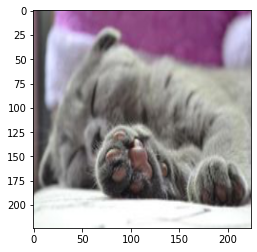

In [10]:
# Checking contents:
plt.imshow(dataset_train[46][0].permute(1,2,0))

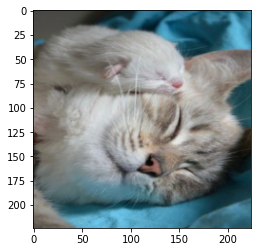

In [11]:
# Checking contents:
plt.imshow(dataset_test[46][0].permute(1,2,0))

In [ ]:
#dataset_test_correctlabel=[(sample,label-1) for sample,label in dataset_test]
#dataset_train_correctlabel=[(sample,label-1) for sample,label in dataset_train]

In [12]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

In [13]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [15]:
model.fc = nn.Linear(model.fc.in_features, 4)
torch.nn.init.xavier_uniform_(model.fc.weight)

Parameter containing:
tensor([[ 0.0609, -0.0690,  0.0445,  ..., -0.0013, -0.0052,  0.0700],
        [-0.0615, -0.0253,  0.0578,  ..., -0.1027,  0.0001, -0.0791],
        [-0.0817,  0.0278,  0.0599,  ..., -0.0189, -0.0286,  0.0517],
        [ 0.0346,  0.0225,  0.0178,  ..., -0.0144, -0.0883, -0.0613]],
       requires_grad=True)

In [16]:
torch.cuda.device_count()

1

In [17]:
device = torch.device('cuda:0')
model = model.to(device)

In [18]:
# Created class that takes learning rate, momentum factor, learning rate scheduler, and minibatch size to easily change variables and experiment for Task 5
class TransferLearning:


   def __init__(self, learning_rate, momentum_factor, learning_rate_scheduler, minibatch_size, stepSize):
     self.criterion = nn.CrossEntropyLoss()
     self.optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_factor)
     self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=stepSize, gamma=learning_rate_scheduler)
     self.loss_test = 0;
     self.epoch_num = 0;
  
   def run_test(self, model):
     nsamples_test = len(dataset_test)
     loss, correct = 0, 0
     model.eval()
     with torch.no_grad():
         for samples, labels in loader_test:
             samples = samples.to(device)
             labels = labels.to(device)
             outs = model(samples)
             loss += self.criterion(outs, labels)
             _, preds = torch.max(outs.detach(), 1)
             correct_mask = preds == labels
             correct += correct_mask.sum(0).item()
     return loss / nsamples_test, correct / nsamples_test

   def run_train(self, model):
     nsamples_train = len(dataset_train)
     loss_sofar, correct_sofar = 0, 0
     model.train()
     with torch.enable_grad():
         for samples, labels in loader_train:
             samples = samples.to(device)
             labels = labels.to(device)
             self.optimizer.zero_grad()
             outs = model(samples)
             _, preds = torch.max(outs.detach(), 1)
             loss = self.criterion(outs, labels)
             loss.backward()
             self.optimizer.step()
             loss_sofar += loss.item() * samples.size(0)
             correct_sofar += torch.sum(preds == labels.detach())
     self.scheduler.step()
     return loss_sofar / nsamples_train, correct_sofar / nsamples_train

   def run_all(self, model, n_epochs):
     for epoch in range(n_epochs):
         loss_train, acc_train = self.run_train(model)
         self.loss_test, acc_test = self.run_test(model)
         print(f"epoch {self.epoch_num + epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {self.loss_test:.4f} acc {acc_test:.4f}")
     self.epoch_num = self.epoch_num + n_epochs

In [19]:
# accuracy without training
learn = TransferLearning(0.0005, 0.9, 0.1, 10, 4)
learn.run_test(model)

(tensor(0.5861, device='cuda:0'), 0.09583333333333334)

In [20]:
learn.run_all(model, 10)
prev_loss = learn.loss_test

while True:
  learn.run_all(model, 1)
  loss_difference = prev_loss - learn.loss_test
  if (learn.epoch_num > 20):
    break
  prev_loss = learn.loss_test

epoch 0: train loss 0.6916 acc 0.6816, test loss 0.1253 acc 0.7958
epoch 1: train loss 0.4478 acc 0.8184, test loss 0.1174 acc 0.8417
epoch 2: train loss 0.3049 acc 0.8716, test loss 0.0953 acc 0.8542
epoch 3: train loss 0.3072 acc 0.8873, test loss 0.1063 acc 0.8208
epoch 4: train loss 0.1913 acc 0.9228, test loss 0.0971 acc 0.8625
epoch 5: train loss 0.2001 acc 0.9228, test loss 0.0969 acc 0.8500
epoch 6: train loss 0.1902 acc 0.9113, test loss 0.0863 acc 0.8667
epoch 7: train loss 0.1427 acc 0.9374, test loss 0.0906 acc 0.8750
epoch 8: train loss 0.1562 acc 0.9269, test loss 0.1195 acc 0.8417
epoch 9: train loss 0.1689 acc 0.9322, test loss 0.0964 acc 0.8583
epoch 10: train loss 0.1716 acc 0.9301, test loss 0.0940 acc 0.8667
epoch 11: train loss 0.1676 acc 0.9259, test loss 0.0963 acc 0.8708
epoch 12: train loss 0.1605 acc 0.9322, test loss 0.1084 acc 0.8458
epoch 13: train loss 0.1960 acc 0.9071, test loss 0.0944 acc 0.8542
epoch 14: train loss 0.1487 acc 0.9447, test loss 0.0982 a

Optimizing Parameters:

* Top section of the table contains optimized parameters that are compatible with our app integration model

* Bottom section of the table contains overall optimized parameters (not necessarily compatible with app)

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch |
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| ...           | ...      | ...       | ...   | ...       | ...       | ...      | ...        |
| **0.0005** | **0.9** | **8** | **0.1** | 1 | 0.2718  | 0.7035| 14
| **0.0005** | **0.9** | **8** | 0.9 | 1 | 0.3730  | 0.6504| 10
| **0.0005** | **0.9** | **8** | 0.5 | 1 | 0.3148  | 0.6770| 9
| **0.0005** | **0.9** | 4 | 0.1 | 1 | 0.2684  | 0.6504| 10
| **0.0005** | **0.9** | 12 | 0.1 | 1 | 0.3088  | 0.6726| 17
| **0.0005** | **0.9** | 10 | 0.1 | 1 | 0.3179  | 0.6681| 19
| **0.0005** | **0.9** | 5 | 0.1 | 1 | 0.2794  | 0.6637| 16
| **0.0005** | 0.5 | **8** | 0.1 | 1 | 0.2414  | 0.6593 | 6
| **0.0005** | 0.2 | **8** | 0.1 | 1 | 0.2622  | 0.6239 | 13
| 0.005 | **0.9** | **8** | 0.1 | 1 | 0.4175  | 0.4248 | 10
| 0.01 | **0.9** | **8** | 0.1 | 1 | 0.3620  | 0.3850 | 12
| 0.000001 | **0.9** | **8** | 0.1 | 1 | 0.3788 | 0.3496 | 12
| 0.1 | **0.9** | **8** | 0.1 | 1 | 0.3922 | 0.3142 | 19
| 0.001 | **0.9** | **8** | 0.1 | 1 | 0.3316 | 0.6549 | 11
| ... | ... | ... | ... | ... | ... | ... | ... |
| 0.001 | 0.9 | 8 | 0.1 | 5 | 0.3408 | 0.6637 | 20
| 0.1 | 0.9 | 8 | 0.1 | 5 | 0.3492 | 0.4027 | 12
| 0.000001 | 0.9 | 8 | 0.1 | 5 | 0.4359 | 0.3363 | 20
| 0.01 | 0.9 | 8 | 0.1 | 5 | 0.3217 | 0.4292 | 20
| 0.005 | 0.9 | 8 | 0.1 | 5 | 0.3417 | 0.4381 | 8
| **0.0005** | 0.5 | 8 | 0.1 | 5 | 0.2521 | 0.6062 | 11
| **0.0005** | 0.2| 8 | 0.1 | 5 | 0.2577 | 0.6239 | 14
| **0.0005** | 0.8| 8 | 0.1 | 5 | 0.2682 | 0.6681 | 11
| **0.0005** | **0.9** | 5 | 0.1 | 5 | 0.3160 | 0.6549 | 19
| **0.0005** | **0.9** | 10 | 0.1 | 5 | 0.2862 | 0.6858 | 14
| **0.0005** | **0.9** | 12 | 0.1 | 5 | 0.3171 | 0.6637 | 16
| **0.0005** | **0.9** | **8** | 0.5 | 5 | 0.3367 | 0.6726 | 17
| **0.0005** | **0.9** | **8** | 0.9 | 5 | 0.3137 | 0.6504 | 11
| **0.0005** | **0.9** | **8** | **0.1** | 5 | 0.2966 | 0.6903 | 20
| **0.0005** | **0.9** | **8** | **0.1** | 8 | 0.3185 | 0.6549 | 14
| **0.0005** | **0.9** | **8** | **0.1** | 3 | 0.2908 | 0.6814 | 11
| **0.0005** | **0.9** | **8** | **0.1** | 2 | 0.2872 | 0.6504 | 10
| **0.0005** | **0.9** | **8** | **0.1** | **4** | 0.2834 | 0.7168 | 20


May use transforms.Rotation/VerticalFlip/... 

In [ ]:
# Code taken from tutorial video at https://www.youtube.com/watch?v=5Lxuu16_28o&ab_channel=PyTorch

# model.qconfig = torch.quantization.get_default_qconfig('qnnpack')

In [ ]:
# torch.quantization.prepare(model,inplace=True)

In [ ]:
# def calibrate(model,calibration_data):
#   return
# calibrate(model, [])

In [ ]:
# model_quant = torch.quantization.QuantStub()

In [ ]:
# model = torch.quantization.convert(model_quant,inplace=True)

- cpu_model = gpu_model.cpu()
- sample_input_cpu = sample_input_gpu.cpu()
- traced_cpu = torch.jit.trace(traced_cpu, sample_input_cpu)
- torch.jit.save(traced_cpu, "cpu.pth")

In [21]:
cpu_model = model.cpu()
example = torch.rand(1, 3, 224, 224)
traced_cpu = torch.jit.trace(cpu_model, example)
torch.jit.save(traced_cpu, "cpu_model.pt")

In [ ]:
#  torchscript_model = torch.jit.script(model)

In [ ]:
# torchscript_model_optimized = optimize_for_mobile(torchscript_model)

In [ ]:
# model.eval()

In [ ]:
# # example = torch.rand(1, 3, 224, 224)
# traced_script_module = torch.jit.script(model)
# traced_script_module.save("model.pt")

In [ ]:
# example

In [ ]:
# torch.jit.save(torchscript_model_optimized, 'image_model.pt')

In [ ]:
# i = 0
# for samples,labels in loader_test:
#   s = (samples)
#   l = labels
#   samples = samples.to(device)
#   s = samples
#   out = model(samples)
#   i+= 1
#   if i == 11:
#     break

In [ ]:
# out

In [ ]:
# model.eval()

In [ ]:
# s.shape

In [ ]:
# l

In [ ]:
# s.shape

In [ ]:
# out.shape

In [ ]:
# t,p = torch.max(out,1)

In [ ]:
# t.shape

In [ ]:
# p.shape

In [ ]:
# p.to(device)

In [ ]:
torch.sum(p== l.detach())

In [ ]:
out = model(s)

In [ ]:
out

In [ ]:
out.detach()